This notebook will cover molecular library enumeration using a rule-based approach. We will leverage chemically reasonable mutations framework for structure generation - [CReM](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00431-w). In brief, scaffolds are modified by adding chemical substructures that exist within similar chemical contexts (attachment points) in other real-world molecules, making all these compounds chemically feasible.

In [ ]:
#First we need to import crem as well as other required packages
!pip install crem
!pip install pandas
!pip install rdkit-pypi
!pip install umap-learn
!pip install matplotlib
!pip install tqdm

In [7]:
#Next from our scaffold set of SMARTS codes, we need to replace wildcards (*) with hydrogens

from rdkit import Chem

def replace_wildcards_with_hydrogens(smarts_code):
    return smarts_code.replace('*', '[H]')

def smarts_to_canonical_smiles(smarts_code):
    updated_smarts = replace_wildcards_with_hydrogens(smarts_code)
    mol = Chem.MolFromSmarts(updated_smarts)  # Convert SMARTS to RDKit molecule
    if mol is None:
        return None  # Invalid SMARTS, skip
    # Convert to canonical SMILES and remove explicit hydrogens
    canonical_smiles = Chem.MolToSmiles(mol, canonical=True)
    return canonical_smiles

def process_smarts_file(input_file, output_file):
    total_smarts = 0
    invalid_smarts_count = 0

    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            smarts_code = line.strip()  # Remove leading/trailing whitespace
            canonical_smiles = smarts_to_canonical_smiles(smarts_code)
            if canonical_smiles:  # Only write valid SMILES
                outfile.write(canonical_smiles + '\n')

# Modify file paths here
input_file = '/content/scaffolds random.smi'   # Replace with the path to your input file
output_file = '/content/scaffolds_converted.smi' # Path for the output file

process_smarts_file(input_file, output_file)

In [8]:
#Using our new set of compounds we can create a fragment database for downstream scaffold modification. NOTE: You can create a fragment database from
#any chemical repository

#Fragment database

!crem_create_frag_db.sh /content/scaffolds_converted.csv fragdb_dir 32

3000 lines passed

In [ ]:
#To see the effects we can mutate a single molecule from the scaffold database

from crem.crem import mutate_mol, grow_mol, link_mols
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw

#Disable rdkit messages
RDLogger.DisableLog("rdApp.*")

#mutate mol. Max size can be adjusted
m = Chem.MolFromSmiles('c2ccc(CN1CCNCC1)cc2')  # methoxytoluene
mols = list(mutate_mol(Chem.AddHs(m), db_name='/content/fragdb_dir/fragments.db', max_size=1))
molecules = [Chem.MolFromSmiles(smiles) for smiles in mols]

# Draw the molecules
img = Draw.MolsToGridImage(molecules, subImgSize=(300, 300), molsPerRow=5)

# Display the image
img

In [ ]:
#To apply this to a list of compounds we can use the following code. This can take awhile so be mindful about
#max_size parameter (higher max_size = more compounds).

#This will perform mutation (analog enumeration)


import pandas as pd
import random
from crem.crem import mutate_mol
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from tqdm import tqdm

# Disable RDKit messages
RDLogger.DisableLog("rdApp.*")

# Read SMILES from a text file (one SMILES per line, no header)
input_file = '/content/scaffolds_converted.smi'  # Adjust the file path
with open(input_file, 'r') as file:
    smiles_list = [line.strip() for line in file.readlines()]

# List to store all mutated SMILES
all_mutated_smiles = []

# Loop over each SMILES string in the file
for smiles in tqdm(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    if mol:  # Check if the molecule is valid
        # Mutate the molecule
        mutated_mols = list(mutate_mol(Chem.AddHs(mol), db_name='/content/fragdb_dir/fragments.db', max_size=5))
        all_mutated_smiles.extend(mutated_mols)

# Save mutated SMILES to a CSV
output_df = pd.DataFrame(all_mutated_smiles, columns=['mutated_smiles'])
output_df.to_csv('mutated_smiles.csv', index=False, header=False)

# Select 50 random SMILES to visualize
random_smiles = random.sample(all_mutated_smiles, min(50, len(all_mutated_smiles)))

# Convert the SMILES to RDKit molecules
random_molecules = [Chem.MolFromSmiles(smiles) for smiles in random_smiles]

# Draw the molecules with a maximum of 5 molecules per row
img = Draw.MolsToGridImage(random_molecules, subImgSize=(300, 300), molsPerRow=5)

# Display the image
img



In [ ]:
#This script is similar to above, but will perform growing (scaffold decoration)

import pandas as pd
import random
from crem.crem import grow_mol
from rdkit import Chem, RDLogger
from rdkit.Chem import Draw
from tqdm import tqdm

# Disable RDKit messages
RDLogger.DisableLog("rdApp.*")

# Read SMILES from a text file (one SMILES per line, no header)
input_file = '/content/scaffolds_converted.smi'  # Adjust the file path
with open(input_file, 'r') as file:
    smiles_list = [line.strip() for line in file.readlines()]

# List to store all grown SMILES
all_grown_smiles = []

# Loop over each SMILES string in the file
for smiles in tqdm(smiles_list):
    mol = Chem.MolFromSmiles(smiles)
    if mol:  # Check if the molecule is valid
        # Grow the molecule
        grown_mols = list(grow_mol(Chem.AddHs(mol), db_name='/content/fragdb_dir/fragments.db'))
        all_grown_smiles.extend(grown_mols)

# Save grown SMILES to a CSV
output_df = pd.DataFrame(all_grown_smiles, columns=['grown_smiles'])
output_df.to_csv('grown_smiles.csv', index=False, header=False)

# Select 50 random SMILES to visualize
random_smiles = random.sample(all_grown_smiles, min(50, len(all_grown_smiles)))

# Convert the SMILES to RDKit molecules
random_molecules = [Chem.MolFromSmiles(smiles) for smiles in random_smiles]

# Draw the molecules with a maximum of 5 molecules per row
img = Draw.MolsToGridImage(random_molecules, subImgSize=(300, 300), molsPerRow=5)

# Display the image
img


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/usr/local/lib/python3.10/dist-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling bac

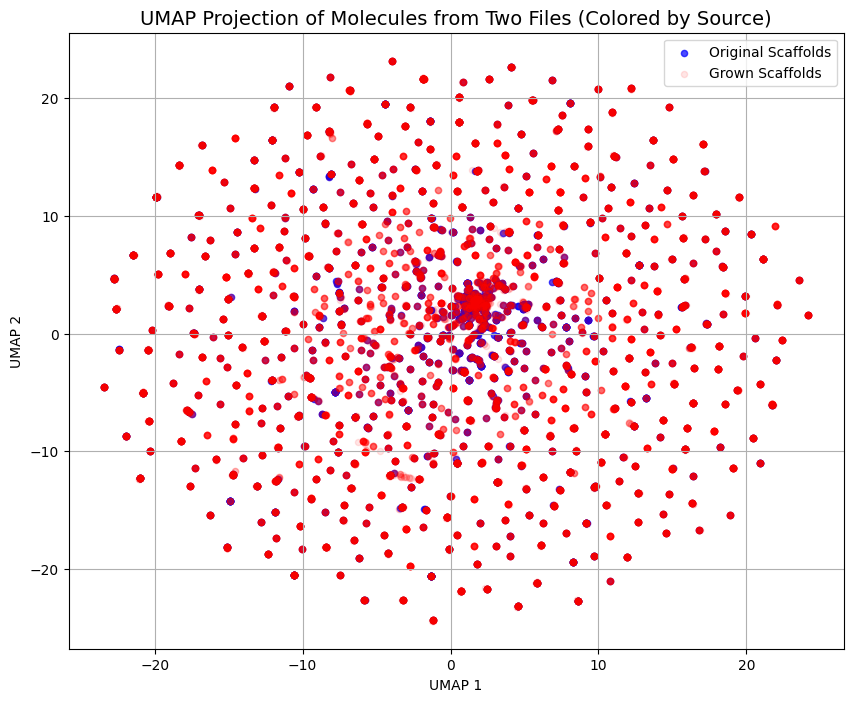

In [44]:
#This will plot the chemical space occupied by the original scaffolds and new mutated (or grown) molecules using UMAP. This will show that new molecules
#explore new regions of chemical space!

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Function to read SMILES from a text file
def read_smiles(file):
    with open(file, 'r') as f:
        smiles_list = [line.strip() for line in f.readlines()]
    return smiles_list

# Function to calculate Morgan fingerprints (radius 2, 1024 bits)
def calculate_fingerprints(smiles_list):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols if mol]
    return fingerprints

# Read SMILES from two separate files
file1 = '/content/scaffolds_converted.smi'  # Adjust the file paths
file2 = '/content/mutated_smiles.csv'

smiles_file1 = read_smiles(file1)
smiles_file2 = read_smiles(file2)

# Calculate Morgan fingerprints for each file
fps_file1 = calculate_fingerprints(smiles_file1)
fps_file2 = calculate_fingerprints(smiles_file2)

# Combine fingerprints into one dataset
fps_combined = fps_file1 + fps_file2

# Convert fingerprints to numpy array
fps_array = np.array([list(fp) for fp in fps_combined])

# Apply standard scaling before UMAP
scaler = StandardScaler()
fps_scaled = scaler.fit_transform(fps_array)

# Perform UMAP dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
embedding = umap_model.fit_transform(fps_scaled)

# Separate UMAP embeddings for file1 and file2
embedding_file1 = embedding[:len(fps_file1)]
embedding_file2 = embedding[len(fps_file1):]

# Plot UMAP result with different alpha values for file1 (blue) and file2 (red)
plt.figure(figsize=(10, 8))

# Plot molecules from file1 (blue, more opaque)
plt.scatter(embedding_file1[:, 0], embedding_file1[:, 1], c='blue', alpha=0.7, s=20, label='Original Scaffolds')

# Plot molecules from file2 (red, more transparent)
plt.scatter(embedding_file2[:, 0], embedding_file2[:, 1], c='red', alpha=0.1, s=20, label='Grown Scaffolds')

# Plot settings
plt.title('UMAP Projection of Molecules from Two Files (Colored by Source)', fontsize=14)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.grid(True)
plt.show()
